# Backpropagation Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff

## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- ~~Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.~~
- ~~Random weight initialization with small random weights with mean of 0 and a variance of 1.~~
- ~~Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e., do not attempt batch updates)~~
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- ~~Option to include a momentum term~~

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [2]:
class MLP(BaseEstimator,ClassifierMixin):
    def __init__(self,lr=.1, momentum=0, shuffle=True,hidden_layer_widths=None):
        " Initialize class with chosen hyperparameters."
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.weights = None
        self.prev_dw = None
        self.MSEs = None
        self.scores = None
    
    def __str__(self):
        output = ""
        for i, layer in enumerate(self.weights):
            output += f"Layer {i}\n"
            for row in layer:
                output += str(row.tolist())
                output += '\n'
            output += '\n'
        return output

    def fit(self, X, y, initial_weights=None, n_epochs = 1, no_change=False, validation_prop=.15):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets.
            y (array-like): A 2D numpy array with the training targets.
            initial_weights (array-like): allows the user to provide initial weights.
            n_epochs (int): Number of epochs for which to run.
            no_change (bool): If true, runs until `n_epochs` without change.
                    If false, runs deterministically for `n_epochs` epochs.
            validation_prop (float): Proportion of training set to be randomly separated as a validation set.
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        num_outputs = y.shape[1] if y.ndim > 1 else max(y)
        self.weights = self.initialize_weights(X, num_outputs) if not initial_weights else initial_weights
        self.MSEs = []
        prev_dw = [np.zeros_like(layer) for layer in self.weights]
        
        curr_epoch = n_epochs
        best_score = 0
        self.scores = []
        while curr_epoch:
            self._shuffle_data(X, y)
            for row, targets in zip(X, y):
                Z_list = self._forward_prop(row)
                weight_updates = self._backprop(targets, Z_list)
                for layer, update, prev_update in zip(self.weights, weight_updates, prev_dw):
                    update += self.momentum * prev_update
                    layer += update
                prev_dw = weight_updates
                
            # Calculate MSE
            MSE = lambda T, O: sum((t-o)**2 for t, o in zip(T, O))/len(T)
            val_idx = max(int(len(X)*validation_prop),1)
            validation_X, validation_y = X[:val_idx], y[:val_idx]
            predictions = np.array([self._forward_prop(row)[-1] for row in validation_X])
            self.MSEs.append(sum(MSE(validation_y, predictions)))
            
            score = self.score(X,y)
            self.scores.append(score)
            
            curr_epoch -= 1
            if no_change and score > best_score:
                curr_epoch = n_epochs
                best_score = score
        return self

    def initialize_weights(self, X, n_outputs):
        """ Initialize weights for perceptron. Don't forget the bias! """
        n = X.shape[1]
        if self.hidden_layer_widths is None:
            self.hidden_layer_widths = [2*n]
        self.weights = []
        for m in self.hidden_layer_widths:
            self.weights.append(np.random.randn(n+1,m))
            n = m
        self.weights.append(np.random.randn(n+1,n_outputs))
        return self.weights
 
    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        outputs = []
        for row in X:
            output = self._forward_prop(row)[-1]
            outputs.append(np.where(output == max(output), 1, 0))
        return np.array(outputs)
    
    def _forward_prop(self, X):
        sigmoid = lambda x: 1/(1 + np.exp(-x))
        Z = X.copy()
        Z_list = []
        for i, layer in enumerate(self.weights):
            Z = np.append(Z, 1)
            Z_list.append(Z)
            Z = sigmoid(Z@layer)
        Z_list.append(Z)
        return Z_list
    
    def _backprop(self, targets, Z_list):
        # Error = Δw_ij = C*δ_j*Z_i
        output = Z_list.pop()
        update_weights = []
        # Calculate output error: δ_j = (T_j - Z_j)*Z_j*(1-Z_j)
        δ_prev = (targets - output)*output*(1-output)
        Z = Z_list[-1][:, None]
        update_weights.append(self.lr*Z@δ_prev[None])
        
        # Calculate hidden node layer: δ_j = (T_j - Z_j)*Z_j*(1-Z_j)
        for i, (prev_weights, next_Z, curr_Z) in enumerate(zip(self.weights[::-1], Z_list[-2::-1], Z_list[::-1])):
            δ_matrix = prev_weights@δ_prev[:, None]
            δ_matrix = δ_matrix[:-1].flatten() # Not considering bias
            curr_Z = curr_Z[:-1]
            δ = δ_matrix*curr_Z*(1-curr_Z)
            next_Z = next_Z[:, None]
            update_weights.append(self.lr*next_Z@δ[None])
            δ_prev = δ
        
        update_weights.reverse()
        return update_weights

    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets

        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        return np.sum(self.predict(X) == y)/y.size
        

    def _shuffle_data(self, X, y):
        if not self.shuffle:
            return X, y
        output_cols = y.shape[1] if y.ndim > 1 else 1
        data = np.c_[X, y]
        np.random.shuffle(data)
        return data[:,:-output_cols], data[:,-output_cols]

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights
    


## 0.1 Homework Example

In [3]:
X = np.array([[-1, .4]])
y = np.array([.2])
mlp = MLP(lr=1)
initial_weights = [
    np.array([[.4896, .4896], [.4931, .4931], [.4885, .4885]]),
    np.array([[.3964], [.3964], [.3667]])
]
mlp.fit(X, y, initial_weights)
mlp

MLP(lr=1)

## 1.1 

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://byu.instructure.com/courses/14142/files?preview=4421290)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://byu.instructure.com/courses/14142/files?preview=4537323) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://byu.instructure.com/courses/14142/files?preview=4537340) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

In [4]:
# Load debug data
data, meta = arff.loadarff("data/debug.arff")
data = np.array([[*row] for row in data])
X, y = data[:,:-1].astype(float), data[:,-1]
unique_key, category_vals = np.unique(data[:,-1], return_inverse=True)
onehot_y = np.zeros((y.size, len(unique_key))).astype(int)
onehot_y[np.arange(y.size), np.abs(1-category_vals)] = 1
y = onehot_y

# print(X, y)
# Train on debug data
mlp = MLP(shuffle=False, momentum=.5)
initial_weights = [np.zeros((3,4)), np.zeros((5,2))]
mlp.fit(X, y, initial_weights, n_epochs=9, no_change=True)

# Print weights
mlp

MLP(momentum=0.5, shuffle=False)

### 1.1.2 Evaluation

Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

We will evaluate your model based on printed weights after training on the [Evaluation Dataset](https://byu.instructure.com/courses/14142/files?preview=4421294)

In [5]:
# Load evaluation data
data, meta = arff.loadarff("data/eval.arff")
data = np.array([[*row] for row in data])
X, y = data[:,:-1], data[:,-1]
X = X.astype(float)
unique_key, category_vals = np.unique(data[:,-1], return_inverse=True)
onehot_y = np.zeros((y.size, len(unique_key))).astype(int)
onehot_y[np.arange(y.size), np.abs(1-category_vals)] = 1
y=onehot_y

# Train on evaluation data
mlp = MLP(shuffle=False, momentum=.5)
initial_weights = [np.zeros((X.shape[1]+1, 4)), np.zeros((5, 2))]
print("X = ", X.shape)
print("y = ", y.shape)
mlp.fit(X, y, initial_weights, n_epochs=10)

# Print weights
mlp

X =  (1372, 4)
y =  (1372, 2)


MLP(momentum=0.5, shuffle=False)

## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://byu.instructure.com/courses/14142/files?preview=4421369)

Parameters:
- ~~One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.~~
- ~~Use a 80/20 split of the data for the training/test set.~~
- ~~Use a learning rate of 0.1~~
- ~~Use a validation set (15% of the training set) taken from the training set for your stopping criteria~~
- ~~Create one graph with MSE (mean squared error) over epochs from the training set and validation set~~
- ~~Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set~~
- ~~Print out your test set accuracy~~

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

Test accuracy:  97.778 %
Number of epochs run: 203


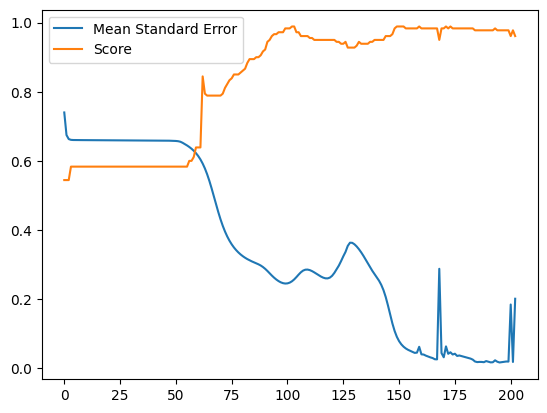

In [6]:
# Iris Classification
# For some reason my accuracy varies wildly. It ranges anywhere between 50% to 100%, but usually hangs between 93-97%.
#     Not sure why it does this, but if there is a really low accuracy when you run it, just run this cell again and it should improve.
#     The only thing that would influence this is the data shuffling. Weird.
# Prepare data
data, meta = arff.loadarff("data/iris.arff")
data = np.array([[*row] for row in data])
np.random.shuffle(data)
X, y = data[:,:-1].astype(float), data[:,-1]
train_prop = .8
X_train, X_test = X[:int(train_prop*len(X))], X[int(train_prop*len(X)):]
unique_key, category_vals = np.unique(data[:,-1], return_inverse=True)
onehot_y = np.zeros((y.size, len(unique_key))).astype(int)
onehot_y[np.arange(y.size), category_vals] = 1

y_train, y_test = onehot_y[:int(train_prop*len(y))], onehot_y[int(train_prop*len(y)):]

mlp = MLP(hidden_layer_widths=[3,4])
mlp.fit(X_train, y_train, n_epochs=100, no_change=True)
print("Test accuracy: ", round(mlp.score(X_test, y_test)*100, 3), "%")
print(F"Number of epochs run: {len(mlp.MSEs)}")
plt.plot(mlp.MSEs, label = "Mean Standard Error")
plt.plot(mlp.scores, label = "Score")
plt.legend(loc = "upper left")

## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://byu.instructure.com/courses/14142/files?preview=4537354)

- ~~Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.~~
- ~~Use random 80/20 splits of the data for the training/test set.~~
- ~~Use a validation set (15% of the training set) taken from the training set for your stopping criteria **Question: can this be separated out at each epoch?**~~
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn. 

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

In [7]:
# Train on each datasets
data, meta = arff.loadarff("data/vowel.arff")
data = np.array([[*row] for row in data])
data = data[:,2:]
meta

Dataset: vowel
	Train or Test's type is nominal, range is ('Train', 'Test')
	Speaker Number's type is nominal, range is ('Andrew', 'Bill', 'David', 'Mark', 'Jo', 'Kate', 'Penny', 'Rose', 'Mike', 'Nick', 'Rich', 'Tim', 'Sarah', 'Sue', 'Wendy')
	Sex's type is nominal, range is ('Male', 'Female')
	Feature 0's type is numeric
	Feature 1's type is numeric
	Feature 2's type is numeric
	Feature 3's type is numeric
	Feature 4's type is numeric
	Feature 5's type is numeric
	Feature 6's type is numeric
	Feature 7's type is numeric
	Feature 8's type is numeric
	Feature 9's type is numeric
	Class's type is nominal, range is ('hid', 'hId', 'hEd', 'hAd', 'hYd', 'had', 'hOd', 'hod', 'hUd', 'hud', 'hed')

Testing Learning Rate = 0.01
Testing Learning Rate = 0.04
Testing Learning Rate = 0.16
Testing Learning Rate = 0.64
Testing Learning Rate = 2.56


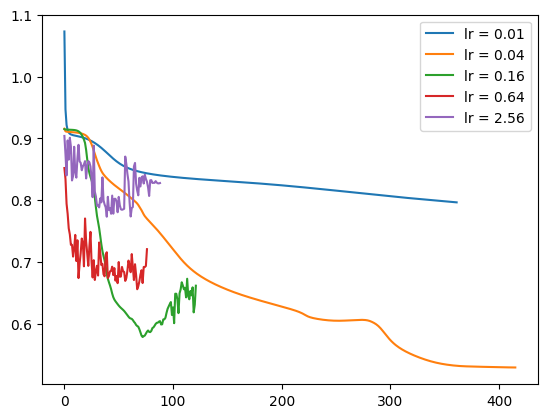

SCORES
0.01: 85.31%
0.04: 93.76%
0.16: 89.16%
0.64: 88.06%
2.56: 84.85%
BEST LEARNING RATE : 0.04


In [8]:
data, meta = arff.loadarff("data/vowel.arff")
data = np.array([[*row] for row in data])
data = data[:,2:]
data[:,0] =  np.where(data[:,0] == b'Male', 1, 0)
np.random.shuffle(data)
X, y = data[:,:-1].astype(float), data[:,-1]
train_prop = .8
X_train, X_test = X[:int(train_prop*len(X))], X[int(train_prop*len(X)):]
unique_key, category_vals = np.unique(data[:,-1], return_inverse=True)
onehot_y = np.zeros((y.size, len(unique_key))).astype(int)
onehot_y[np.arange(y.size), category_vals] = 1

y_train, y_test = onehot_y[:int(train_prop*len(y))], onehot_y[int(train_prop*len(y)):]

#Train model
lr_0 = lr = .01
MSE_dict = dict()
scores_dict = dict()
num_lr = 5
for i in range(num_lr):
    print(f"Testing Learning Rate = {lr}")
    mlp = MLP(hidden_layer_widths=[3,4], lr=lr, momentum=.5)
    mlp.fit(X_train, y_train, n_epochs=50, no_change=True)
    MSE_dict[lr] = mlp.MSEs
    scores_dict[lr] = mlp.score(X_test, y_test)
    lr *= 4
 
for k, MSEs in MSE_dict.items():
    plt.plot(MSEs, label=f"lr = {k}")
plt.legend(loc = "upper right")
plt.show()
print("SCORES")
for lr, score in scores_dict.items():
    print(f"{lr}: {round(score*100,2)}%")
    
best_lr = max(scores_dict, key=scores_dict.get)
print(F"BEST LEARNING RATE : {best_lr}")

## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates. 
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies. 
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, etc.) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.<br><br>-------------------------------------------------------------------------------------<br>



**Discuss the effect of varying learning rates.**<br>
There was definately a sweet spot for the learning rates. If it was too low, the model didn't improve its accuracy quickly enough before it hit a number of epochs without improvement that cut off the training. If it was too high, it learned quickly but also un-learned quickly: before it could "lock in" what it learned, the weights would swing too far in the other direction and decrease accuracy. The best balance I found was around **0.04**.
<br>
What's interesting is that, to debug it without taking too long, I was originally running it deterministically for `50` epochs (rather than `50` epochs without improvement). When I ran it like that, the best balance was **0.16**. You can also see this on the graph, where until approximately epoch `125`, the learning rate of `.16` beat out the `0.04`. This is likely due to the same reason that I previously mentioned, and made me wonder if, with more computation, the best learning rate would be `0.01`.
<br><br>
**Discuss why the vowel data set might be more difficult than Iris. Report both datasets' baseline accuracies and best test set accuracies.**<br>
The vowel dataset has a lot more outputs, making it more difficult to distinguish between two closely related classes. This can be seen by the **baseline accuracies**, or the accuracies if the outcome was guessed at random. With three outputs in the iris dataset, randomly guessing the class would give an accuracy of approximately **33%**. However, with the 11 outputs in the vowel dataset, randomly guessing would yield an accuracy of approximately **9%**. Thus, more outputs means a more difficult dataset.<br><br>
**Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, etc.) and discuss why you chose the ones you did.**<br>
It was difficult to determine which features to use, as I couldn't find a clear explanation on what they were. However, I did exclude the `Train/Test` and `Name` features. I figured that the name of the person wouldn't correlate well with how they pronounced their vowels. However, I didn't exclude the `Gender` feature, as I was curious if that would impact it.


## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

Testing 1 hidden nodes...
Testing 2 hidden nodes...
Testing 4 hidden nodes...
Testing 8 hidden nodes...
Testing 16 hidden nodes...
Testing 32 hidden nodes...
Testing 64 hidden nodes...
Testing 128 hidden nodes...


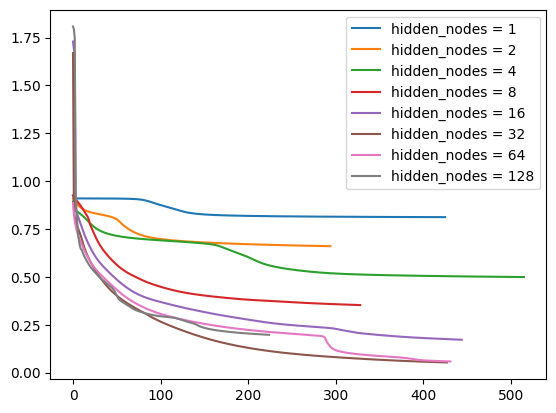

SCORES
1: 86.59%
2: 90.91%
4: 92.75%
8: 94.58%
16: 97.8%
32: 98.16%
64: 99.27%
128: 95.78%
BEST HIDDEN NODES : 64


In [9]:
# Prepare data
np.random.shuffle(data)
X, y = data[:,:-1].astype(float), data[:,-1]
train_prop = .8
X_train, X_test = X[:int(train_prop*len(X))], X[int(train_prop*len(X)):]
unique_key, category_vals = np.unique(data[:,-1], return_inverse=True)
onehot_y = np.zeros((y.size, len(unique_key))).astype(int)
onehot_y[np.arange(y.size), category_vals] = 1

y_train, y_test = onehot_y[:int(train_prop*len(y))], onehot_y[int(train_prop*len(y)):]

#Train model
hidden_nodes = 1
MSE_dict = dict()
scores_dict = dict()
num_lr = 5
while True:
    print(f"Testing {hidden_nodes} hidden nodes...")
    mlp = MLP(hidden_layer_widths=[hidden_nodes], lr=best_lr, momentum=.5)
    mlp.fit(X_train, y_train, n_epochs=50, no_change=True)
    MSE_dict[hidden_nodes] = mlp.MSEs
    scores_dict[hidden_nodes] = mlp.score(X_test, y_test)
    if hidden_nodes != 1 and scores_dict[hidden_nodes] < scores_dict[hidden_nodes / 2]:
        break
    hidden_nodes *= 2
 
for nodes, MSEs in MSE_dict.items():
    plt.plot(MSEs, label=f"hidden_nodes = {nodes}")
plt.legend(loc = "upper right")
plt.show()
print("SCORES")
for nodes, score in scores_dict.items():
    print(f"{nodes}: {round(score*100,2)}%")
    
best_nodes = max(scores_dict, key=scores_dict.get)
print(F"BEST HIDDEN NODES : {best_nodes}")

*Discuss Hidden Layer Nodes here*<br>-------------------------------------------------------<br>
There were no specifications on what to discuss, so I suppose I'll freestyle. It seems like adding more nodes has diminishing returns. At first, doubling the amount of nodes raises the accuracy significantly (from a `B` grade to an `A-`!). However, past a certain point, doubling the nodes hardly improves things by a fraction of a percent. I stopped the trials when the testing accuracy went down, but the reduction wasn't very significant. Perhaps pas that point, the accuracies just bounce around without making much of an impact either way.



## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- For each momentum term, print the test set accuracy. 
- You are trying to see how much momentum speeds up learning and how it affects accuracy.

Testing Learning Rate = 0.01
Testing Learning Rate = 0.04
Testing Learning Rate = 0.16
Testing Learning Rate = 0.64
Testing Learning Rate = 2.56


/tmp/ipykernel_67923/1414599191.py:99: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: 1/(1 + np.exp(-x))
/tmp/ipykernel_67923/1414599191.py:105: RuntimeWarning: overflow encountered in matmul
  Z = sigmoid(Z@layer)
/tmp/ipykernel_67923/1414599191.py:53: RuntimeWarning: overflow encountered in add
  layer += update
/tmp/ipykernel_67923/1414599191.py:52: RuntimeWarning: overflow encountered in multiply
  update += self.momentum * prev_update
/tmp/ipykernel_67923/1414599191.py:105: RuntimeWarning: invalid value encountered in matmul
  Z = sigmoid(Z@layer)


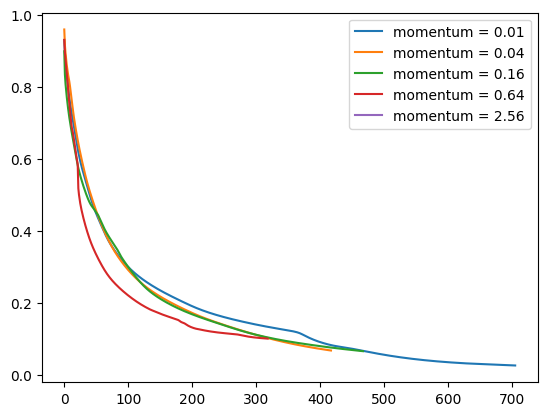

SCORES
0.01: 99.17%
0.04: 99.45%
0.16: 98.35%
0.64: 98.26%
2.56: 90.91%
BEST MOMENTUM : 0.04


In [10]:
# Prepare data
np.random.shuffle(data)
X, y = data[:,:-1].astype(float), data[:,-1]
train_prop = .8
X_train, X_test = X[:int(train_prop*len(X))], X[int(train_prop*len(X)):]
unique_key, category_vals = np.unique(data[:,-1], return_inverse=True)
onehot_y = np.zeros((y.size, len(unique_key))).astype(int)
onehot_y[np.arange(y.size), category_vals] = 1

y_train, y_test = onehot_y[:int(train_prop*len(y))], onehot_y[int(train_prop*len(y)):]

#Train model
m = .01
MSE_dict = dict()
scores_dict = dict()
num_m = 5
for i in range(num_m):
    print(f"Testing Learning Rate = {m}")
    mlp = MLP(hidden_layer_widths=[best_nodes], lr=best_lr, momentum=m)
    mlp.fit(X_train, y_train, n_epochs=50, no_change=True)
    MSE_dict[m] = mlp.MSEs
    scores_dict[m] = mlp.score(X_test, y_test)
    m *= 4
 
for m, MSEs in MSE_dict.items():
    plt.plot(MSEs, label=f"momentum = {m}")
plt.legend(loc = "upper right")
plt.show()
print("SCORES")
for m, score in scores_dict.items():
    print(f"{m}: {round(score*100,2)}%")
    
best_m = max(scores_dict, key=scores_dict.get)
print(F"BEST MOMENTUM : {best_m}")

**Discuss Momentum here**<br>
Unlike the hidden layer nodes, it seems like the momentum definately hurts the score the higher it is. This is likely because it causes the model to overshoot a correction, falling into a higher local minima. It is interesting to note, however, that the best momenta also trained for the longest amount of time. This may indicate that while it is theoretically better to have a lower momentum, it makes training take much longer.



## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
def test_dataset(X, y, n_features, title):
    default_args = {
        "hidden_layer_sizes":[best_nodes],
        "activation": "logistic",
        "solver": "sgd",
        "alpha":0.0001,
        "learning_rate":"constant",
        "learning_rate_init": best_lr,
        "max_iter": 999,
        "shuffle":True,
        "momentum": best_m,
        "nesterovs_momentum": False,
        "early_stopping":True,
    }
    
    variations = {
        "hidden_layer_sizes":[[int(best_nodes/2)], [best_nodes*2], [best_nodes, best_nodes], [int(best_nodes/2), best_nodes, int(best_nodes/2)]],
        "activation": ["tanh", "relu"],
        "learning_rate_init": [best_lr/2, best_lr*2, 0.001, 1],
        "alpha": [0.001, 0.01, 0.00001],
        "momentum": [best_m/2, best_m*2, 0.5, 0.05],
        "nesterovs_momentum": [True],
        "early_stopping":[False],
    }
    
    mlp_args = {"default": default_args}
    for hyperparameter, values in variations.items():
        for value in values:
            args = default_args.copy()
            args[hyperparameter] = value
            mlp_args[f"{hyperparameter} = {value}"] = args
    
    scores = dict()
    speeds = dict()
    for name, args in mlp_args.items():
        print(f"Training on {name}...")
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        mlp = MLPClassifier(**args)
        mlp.fit(X_train, y_train)
        scores[name] = mlp.score(X_test, y_test)
        speeds[name] = mlp.t_
    
    print()
    x, y = [], []
    for name, score in sorted(scores.items(), key=lambda x: x[1]):
        print(name)
        print(f"score = {round(score*100, 2)}%")
        print("training samples seen = ",  speeds[name])
        print()
        x.append(np.log(speeds[name]))
        y.append(score)
        
    plt.scatter(x, y)
    plt.xlabel("Log(training examples seen)")
    plt.ylabel("Testing Accuracy")
    plt.title(title)
    plt.show()
            


Training on default...
Training on hidden_layer_sizes = [32]...
Training on hidden_layer_sizes = [128]...
Training on hidden_layer_sizes = [64, 64]...
Training on hidden_layer_sizes = [32, 64, 32]...
Training on activation = tanh...
Training on activation = relu...
Training on learning_rate_init = 0.02...
Training on learning_rate_init = 0.08...
Training on learning_rate_init = 0.001...
Training on learning_rate_init = 1...
Training on alpha = 0.001...
Training on alpha = 0.01...
Training on alpha = 1e-05...
Training on momentum = 0.02...
Training on momentum = 0.08...
Training on momentum = 0.5...
Training on momentum = 0.05...
Training on nesterovs_momentum = True...
Training on early_stopping = False...

hidden_layer_sizes = [128]
score = 0.0%
training samples seen =  1300

hidden_layer_sizes = [32, 64, 32]
score = 0.0%
training samples seen =  1200

learning_rate_init = 0.08
score = 0.0%
training samples seen =  1200

learning_rate_init = 0.001
score = 0.0%
training samples seen = 

/home/sdsquires/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(


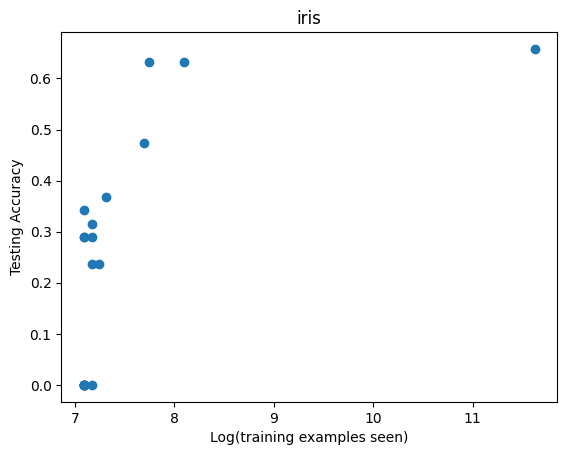



Training on default...
Training on hidden_layer_sizes = [32]...
Training on hidden_layer_sizes = [128]...
Training on hidden_layer_sizes = [64, 64]...
Training on hidden_layer_sizes = [32, 64, 32]...
Training on activation = tanh...
Training on activation = relu...
Training on learning_rate_init = 0.02...
Training on learning_rate_init = 0.08...
Training on learning_rate_init = 0.001...
Training on learning_rate_init = 1...
Training on alpha = 0.001...
Training on alpha = 0.01...
Training on alpha = 1e-05...
Training on momentum = 0.02...
Training on momentum = 0.08...
Training on momentum = 0.5...
Training on momentum = 0.05...
Training on nesterovs_momentum = True...
Training on early_stopping = False...

default
score = 0.0%
training samples seen =  8004

hidden_layer_sizes = [32]
score = 0.0%
training samples seen =  8004

hidden_layer_sizes = [128]
score = 0.0%
training samples seen =  8004

hidden_layer_sizes = [64, 64]
score = 0.0%
training samples seen =  8004

hidden_layer_s

/home/sdsquires/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(


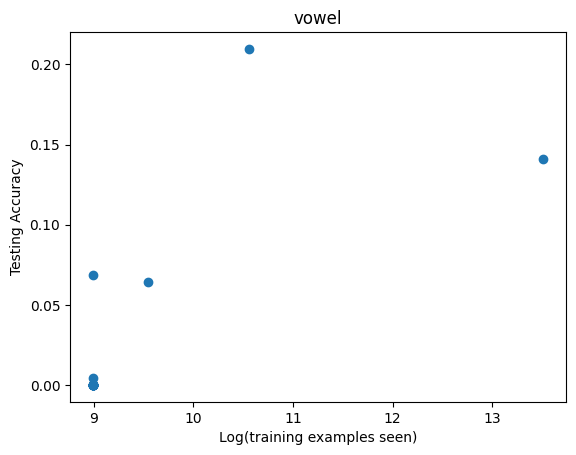

In [12]:
iris, _ = arff.loadarff("data/iris.arff")
iris = np.array([[*row] for row in iris])
np.random.shuffle(iris)
X_iris, y = iris[:,:-1].astype(float), iris[:,-1]
unique_key, category_vals = np.unique(iris[:,-1], return_inverse=True)
onehot_y = np.zeros((y.size, len(unique_key))).astype(int)
onehot_y[np.arange(y.size), category_vals] = 1
y_iris = onehot_y

vowel, _ = arff.loadarff("data/vowel.arff")
vowel = np.array([[*row] for row in vowel])
vowel = vowel[:,2:]
vowel[:,0] =  np.where(vowel[:,0] == b'Male', 1, 0)
np.random.shuffle(vowel)
X_vowel, y = vowel[:,:-1].astype(float), vowel[:,-1]
unique_key, category_vals = np.unique(vowel[:,-1], return_inverse=True)
onehot_y = np.zeros((y.size, len(unique_key))).astype(int)
onehot_y[np.arange(y.size), category_vals] = 1
y_vowel=onehot_y

test_dataset(X_iris, y_iris, X.shape[1], "iris")
print('\n')
test_dataset(X_vowel, y_vowel, X.shape[1], "vowel")


**Record impressions**<br>
As expected, the multilayer perceptron really struggled with the vowel dataset. However, considering that the best model gave you a coinflip-chance to correctly guess rather than a 1-in-10, I'd say it's at least helpful.<br>

The hyperparameter change that had the biggest effect in both groups was the lack of `early stopping`. However, this would likely be the case as it trained for a much longer time than the others. As a result, this might indicate overfitting. However, the three next best hyperparameters didn't require nearly as much training and were common to both datasets: `relu activation`, a `learning rate = 1`, and an `activation function = tanh`. I found it interesting that these were shared like this, since I would assume that the others are useful at different times. I wonder what underlying aspect the two datasets had in common to let this happen!



In [13]:
# Load sklearn perceptron

# Train on voting dataset

*Discuss findings here*